# Data Wrangling with Spark

This is the code used in the previous screencast. Run each code cell to understand what the code does and how it works.

These first three cells import libraries, instantiate a SparkSession, and then read in the data set

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

In [5]:
spark

In [7]:
#path = "../../data/log_data/2018/11/2018-11-15-events.json"
path = "../../data/log_data/2018/11/*.json"
user_log = spark.read.json(path)

# Data Exploration 

The next cells explore the data set.

In [8]:
user_log.take(5)

[Row(artist='Harmonia', auth='Logged In', firstName='Ryan', gender='M', itemInSession=0, lastName='Smith', length=655.77751, level='free', location='San Jose-Sunnyvale-Santa Clara, CA', method='PUT', page='NextSong', registration=1541016707796.0, sessionId=583, song='Sehr kosmisch', status=200, ts=1542241826796, userAgent='"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/36.0.1985.125 Chrome/36.0.1985.125 Safari/537.36"', userId='26'),
 Row(artist='The Prodigy', auth='Logged In', firstName='Ryan', gender='M', itemInSession=1, lastName='Smith', length=260.07465, level='free', location='San Jose-Sunnyvale-Santa Clara, CA', method='PUT', page='NextSong', registration=1541016707796.0, sessionId=583, song='The Big Gundown', status=200, ts=1542242481796, userAgent='"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/36.0.1985.125 Chrome/36.0.1985.125 Safari/537.36"', userId='26'),
 Row(artist='Train', auth='Logged In'

In [9]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: double (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [10]:
user_log.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+------------------+-----+--------------------+------+-------+--------------------+------------------+--------------------+-----------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|            length|level|            location|method|   page|        registration|         sessionId|                song|           status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+------------------+-----+--------------------+------+-------+--------------------+------------------+--------------------+-----------------+--------------------+--------------------+-----------------+
|  count|              6820|      8056|     7770|  7770|              8056|    7770|              6820| 8056|                7770|  8056|   8056|

In [11]:
user_log.describe("artist").show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|              6820|
|   mean|             266.5|
| stddev|109.00229355385143|
|    min|               !!!|
|    max|   ÃÂtienne Daho|
+-------+------------------+



In [12]:
user_log.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|              8056|
|   mean| 598.1675769612712|
| stddev|285.31309422187996|
|    min|                 3|
|    max|              1114|
+-------+------------------+



In [13]:
user_log.count()

8056

In [14]:
user_log.select("page").dropDuplicates().sort("page").show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [16]:
user_log.select(["userId", "firstname", "page", "song"]).where(user_log.userId == "97").collect()

[Row(userId='97', firstname='Kate', page='NextSong', song="Let's Go Crazy (LP Version)"),
 Row(userId='97', firstname='Kate', page='NextSong', song="She's Coming Home"),
 Row(userId='97', firstname='Kate', page='NextSong', song='Numb'),
 Row(userId='97', firstname='Kate', page='NextSong', song='Let There Be Lite (Album Version)'),
 Row(userId='97', firstname='Kate', page='NextSong', song='Nice Weather For Ducks'),
 Row(userId='97', firstname='Kate', page='NextSong', song='Magic'),
 Row(userId='97', firstname='Kate', page='NextSong', song='VIKING MAN'),
 Row(userId='97', firstname='Kate', page='NextSong', song='I Gotta Feeling'),
 Row(userId='97', firstname='Kate', page='NextSong', song='Born To Be Wild'),
 Row(userId='97', firstname='Kate', page='NextSong', song='Willie And The Hand Jive'),
 Row(userId='97', firstname='Kate', page='NextSong', song='Where Is My Mind?'),
 Row(userId='97', firstname='Kate', page='NextSong', song='Girlfriend In A Coma'),
 Row(userId='97', firstname='Kate',

# Calculating Statistics by Hour

In [17]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [18]:
user_log = user_log.withColumn("hour", get_hour(user_log.ts))

In [19]:
user_log.head()

Row(artist='Harmonia', auth='Logged In', firstName='Ryan', gender='M', itemInSession=0, lastName='Smith', length=655.77751, level='free', location='San Jose-Sunnyvale-Santa Clara, CA', method='PUT', page='NextSong', registration=1541016707796.0, sessionId=583, song='Sehr kosmisch', status=200, ts=1542241826796, userAgent='"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/36.0.1985.125 Chrome/36.0.1985.125 Safari/537.36"', userId='26', hour='18')

In [20]:
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))

In [21]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  172|
|   1|  196|
|   2|  207|
|   3|  253|
|   4|  314|
|   5|  322|
|   6|  314|
|   7|  330|
|   8|  444|
|   9|  470|
|  10|  518|
|  11|  491|
|  12|  507|
|  13|  386|
|  14|  367|
|  15|  271|
|  16|  229|
|  17|  200|
|  18|  156|
|  19|  148|
+----+-----+
only showing top 20 rows



In [22]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

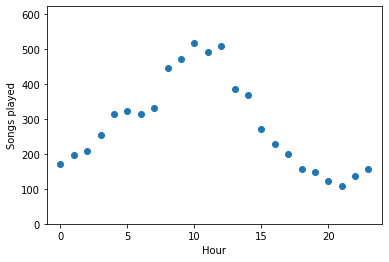

In [23]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

# Drop Rows with Missing Values

As you'll see, it turns out there are no missing values in the userID or session columns. But there are userID values that are empty strings.

In [24]:
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])

In [25]:
user_log_valid.count()

8056

In [26]:
user_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|   101|
|    11|
|    12|
|    13|
|    14|
|    15|
|    16|
|    17|
|    18|
|    19|
|     2|
|    20|
|    21|
|    22|
|    23|
|    24|
|    25|
+------+
only showing top 20 rows



In [27]:
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [28]:
user_log_valid.count()

7770

# Users Downgrade Their Accounts

Find when users downgrade their accounts and then flag those log entries. Then use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.

In [29]:
user_log_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-----------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page|     registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-----------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|     Lily|     F|           23|    Koch|  null| paid|Chicago-Napervill...|   PUT|Submit Downgrade|1.541048010796E12|      764|null|   307|1542798517796|"Mozilla/5.0 (X11...|    15|   5|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-----------------+---------+----+------+-------------+--------------

In [31]:
user_log.select(["userId", "firstname", "page", "level", "song"]).where(user_log.userId == "15").collect()

[Row(userId='15', firstname='Lily', page='NextSong', level='paid', song='Black Hole Sun'),
 Row(userId='15', firstname='Lily', page='NextSong', level='paid', song='Addicted'),
 Row(userId='15', firstname='Lily', page='NextSong', level='paid', song='Air'),
 Row(userId='15', firstname='Lily', page='NextSong', level='paid', song='Superbeast'),
 Row(userId='15', firstname='Lily', page='NextSong', level='paid', song='I Remember'),
 Row(userId='15', firstname='Lily', page='NextSong', level='paid', song="You're The One"),
 Row(userId='15', firstname='Lily', page='NextSong', level='paid', song='Fool'),
 Row(userId='15', firstname='Lily', page='NextSong', level='paid', song='Marguerite'),
 Row(userId='15', firstname='Lily', page='NextSong', level='paid', song='Brothers'),
 Row(userId='15', firstname='Lily', page='NextSong', level='paid', song='My Own Worst Enemy'),
 Row(userId='15', firstname='Lily', page='NextSong', level='paid', song='Time To Pretend'),
 Row(userId='15', firstname='Lily', pag

In [32]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [33]:
user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [34]:
user_log_valid.head()

Row(artist='Harmonia', auth='Logged In', firstName='Ryan', gender='M', itemInSession=0, lastName='Smith', length=655.77751, level='free', location='San Jose-Sunnyvale-Santa Clara, CA', method='PUT', page='NextSong', registration=1541016707796.0, sessionId=583, song='Sehr kosmisch', status=200, ts=1542241826796, userAgent='"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/36.0.1985.125 Chrome/36.0.1985.125 Safari/537.36"', userId='26', hour='18', downgraded=0)

In [35]:
from pyspark.sql import Window

In [36]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [37]:
user_log_valid = user_log_valid.withColumn("phase", Fsum("downgraded").over(windowval))

In [38]:
user_log_valid.select(["userId", "firstname", "ts", "page", "level", "phase"]).where(user_log.userId == "15").sort("ts").collect()

[Row(userId='15', firstname='Lily', ts=1541149281796, page='NextSong', level='paid', phase=1),
 Row(userId='15', firstname='Lily', ts=1541149456796, page='NextSong', level='paid', phase=1),
 Row(userId='15', firstname='Lily', ts=1541149698796, page='NextSong', level='paid', phase=1),
 Row(userId='15', firstname='Lily', ts=1541149952796, page='NextSong', level='paid', phase=1),
 Row(userId='15', firstname='Lily', ts=1541150176796, page='NextSong', level='paid', phase=1),
 Row(userId='15', firstname='Lily', ts=1541150355796, page='NextSong', level='paid', phase=1),
 Row(userId='15', firstname='Lily', ts=1541150563796, page='NextSong', level='paid', phase=1),
 Row(userId='15', firstname='Lily', ts=1541150809796, page='NextSong', level='paid', phase=1),
 Row(userId='15', firstname='Lily', ts=1541151060796, page='NextSong', level='paid', phase=1),
 Row(userId='15', firstname='Lily', ts=1541151325796, page='NextSong', level='paid', phase=1),
 Row(userId='15', firstname='Lily', ts=15411516117

looking at the results, this doesn't look right.  after the user has upgraded her account from `free` to `paid`, the phase doesn't change back to 1